## Mô hình LSTM trong dự báo năng lượng sử dụng

In [2]:
import pandas as pd
data = pd.read_csv("./energy.csv")

In [3]:
data.head()

,Time,Power consumption
0,2019-03-01 0:00,10011.84
1,2019-03-01 0:01,10119.32
2,2019-03-01 0:02,9433.59
3,2019-03-01 0:03,10213.93
4,2019-03-01 0:04,10026.23


In [4]:
"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa dữ liệu về đoạn [0,1]
df = pd.DataFrame(data, columns=["Power consumption"])
values = df.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1,3 )
r = list(range(df.shape[1]+1, 2*df.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed

,var1(t-1),var1(t)
0,0.676143,0.668961
1,0.630324,0.676143
2,0.682464,0.630324
3,0.669923,0.682464
4,0.707974,0.669923
...,...,...
308154,0.598492,0.601722
308155,0.587078,0.598492
308156,0.583641,0.587078
308157,0.589995,0.583641


In [6]:
values = reframed.values
n_train_time = 50000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]   # train_x: n-1 cột đầu tiên, train_y: cột cuối cùng (operation)
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [7]:
units = 64   # hidden_nodes
epochs = 150
batch_size = 70
verbose = 2

In [10]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np 

# build model
model = Sequential()
model.add(LSTM(units, input_shape=(train_x.shape[1], train_x.shape[2]) ))
model.add(Dropout(0.2))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit model
history = model.fit(train_x, train_y, epochs, batch_size, validation_data=(test_x, test_y), verbose=2, shuffle=False)
model.save('model.h5')

Epoch 1/70
334/334 - 16s - loss: 0.0610 - val_loss: 0.0159 - 16s/epoch - 46ms/step
Epoch 2/70
334/334 - 11s - loss: 0.0061 - val_loss: 0.0125 - 11s/epoch - 32ms/step
Epoch 3/70
334/334 - 12s - loss: 0.0052 - val_loss: 0.0088 - 12s/epoch - 35ms/step
Epoch 4/70



KeyboardInterrupt



In [14]:
from keras.models import load_model

model = load_model('model.h5')
size = df.shape[1]

# prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape(test_x.shape[0], size)

#invert scalling
inv_yhat = np.concatenate((yhat, test_x[:,1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape(len(test_y), 1)
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# caculate RSME
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RSME: %.3f' % rmse)

8068/8068 [==============================] - 33s 4ms/step
Test RSME: 586.794


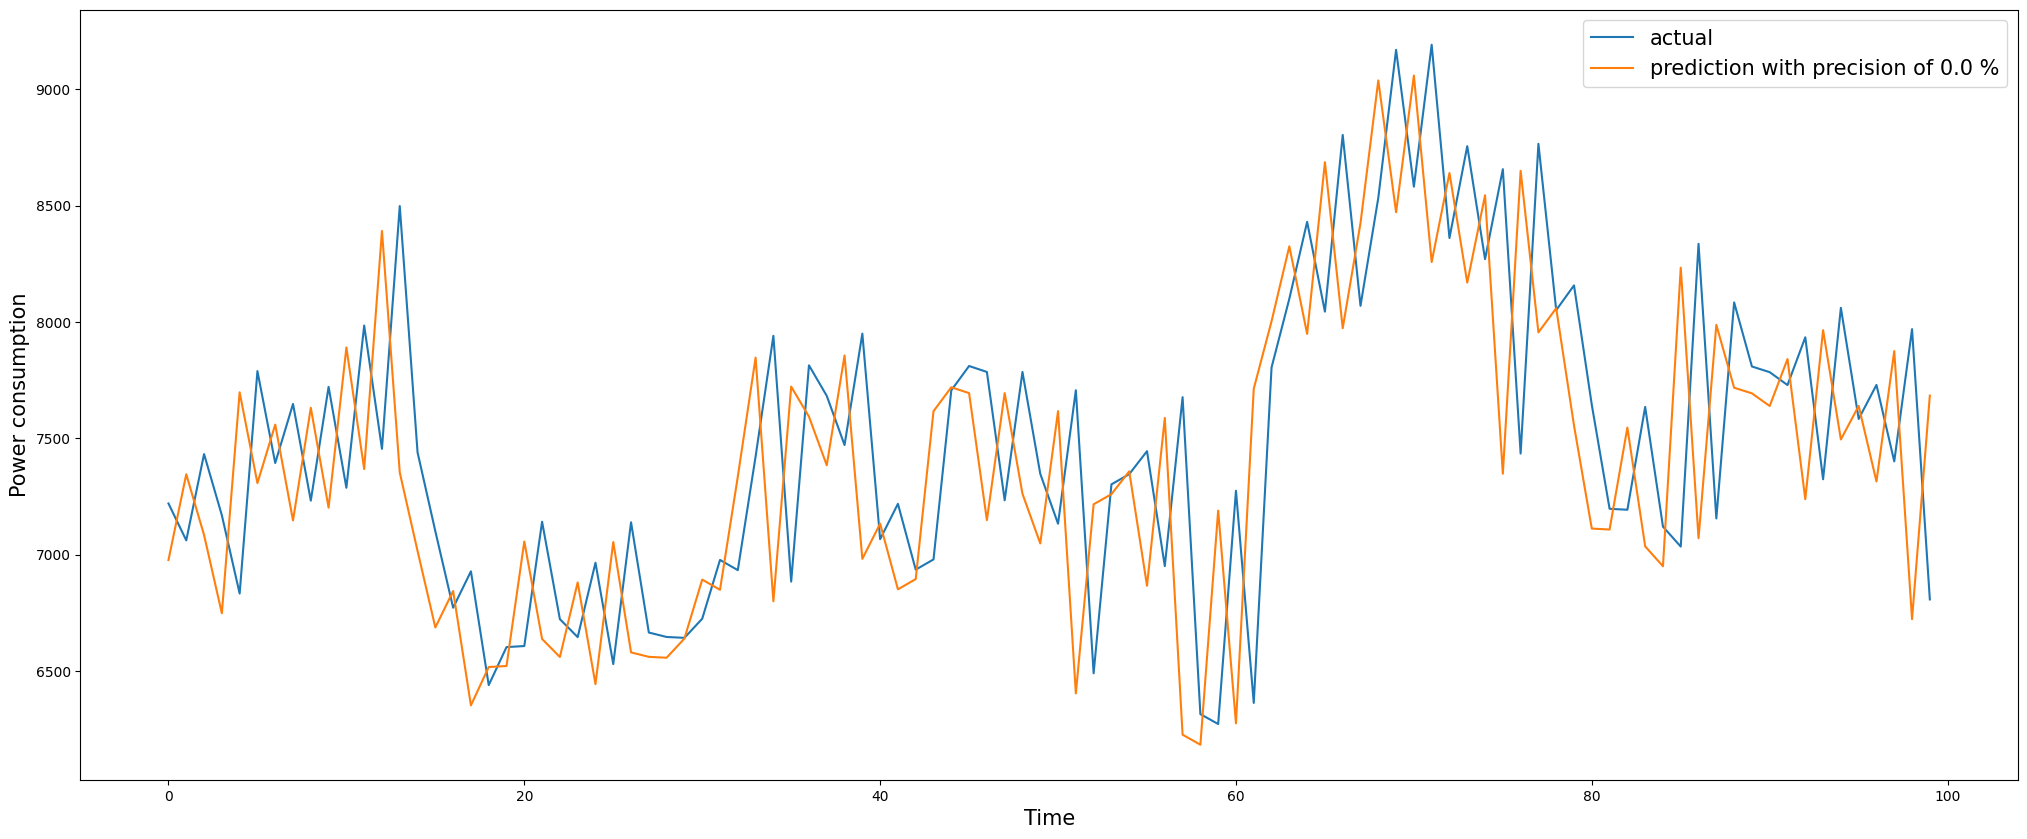

In [13]:
import numpy as np 
e = np.round(sum(np.abs(inv_y[:]-inv_yhat[:]))/(sum(inv_y[:])*len(inv_y[:]))*100,2)
aa=[x for x in range(100)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:100], label="actual")
plt.plot(aa, inv_yhat[:100], label="prediction with precision of {} %".format(e))
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.show()